In [2]:
from pandas.io.data import DataReader
from datetime import datetime
import numpy as np
import pandas as p
from itertools import chain
import matplotlib.pyplot as plt
import operator 
import sys

%matplotlib inline

/Users/Apple/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
#Read training data set

train=np.array(p.read_table('training.csv',sep=','))

In [4]:
#Divided dataset in size of 10 days

def normalize10day(stocks):
    def process_column(i):
        if operator.mod(i, 5) == 1:
            return stocks[:,i] * 0
        if operator.mod(i, 5) == 2:
            return stocks[:,i] * 0
        if operator.mod(i, 5) == 4:
            return stocks[:,i] * 0
            #return np.log(stocks[:,i] + 1)
        else:
            return stocks[:,i] / stocks[:,0]
    n = stocks.shape[0]
    stocks_dat =  np.array([ process_column(i) for i in range(46)]).transpose()
    return stocks_dat

n_windows = 490
windows = range(n_windows)

X_windows = [train[:,range(1 + 5*w, 47 + 5*w)] for w in windows]
X_windows_normalized = [normalize10day(w) for w in X_windows]
X = np.vstack(X_windows_normalized)
y_stockdata = np.vstack([train[:, [46 + 5*w, 49 + 5*w]] for w in windows])
y = (y_stockdata[:,1] > y_stockdata[:,0]) + 0
#print y_stockdata[0,0]
#print X[0,43]
#print y_stockdata[0,1]
#print y_stockdata[0,0]
print X[0]
print y_stockdata[0]

[ 1.       0.       0.       1.       0.       1.       0.       0.       1.
  0.       1.0055   0.       0.       1.       0.       0.98919  0.       0.
  1.0055   0.       0.98385  0.       0.       0.98919  0.       0.98746
  0.       0.       0.98385  0.       0.98558  0.       0.       0.98746
  0.       1.0036   0.       0.       0.98558  0.       1.0072   0.       0.
  1.0036   0.       1.0127 ]
[ 1.0127  1.0072]


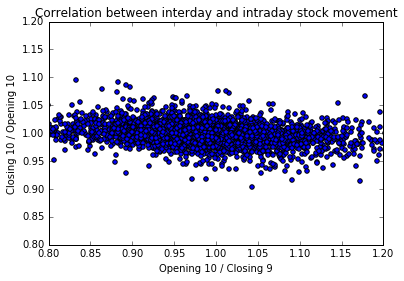

In [5]:
#Trys to find correlation between intraday trading and interday trading

plt.scatter(y_stockdata[range(5000),0]/X[range(5000),43],y_stockdata[range(5000),1]/y_stockdata[range(5000),0])
plt.xlim((.8,1.2)); plt.ylim((.8,1.2))
plt.xlabel("Opening 10 / Closing 9"); plt.ylabel("Closing 10 / Opening 10")
plt.title("Correlation between interday and intraday stock movement")
plt.show()

In [6]:
#Function copied from Ben Hamner Git account to create an AUC scoring function

def tied_rank(x):
    """
    This function is by Ben Hamner and taken from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py

    Computes the tied rank of elements in x.

    This function computes the tied rank of elements in x.

    Parameters
    ----------
    x : list of numbers, numpy array

    Returns
    -------
    score : list of numbers
            The tied rank f each element in x

    """
    sorted_x = sorted(zip(x,range(len(x))))
    r = [0 for k in x]
    cur_val = sorted_x[0][0]
    last_rank = 0
    for i in range(len(sorted_x)):
        if cur_val != sorted_x[i][0]:
            cur_val = sorted_x[i][0]
            for j in range(last_rank, i): 
                r[sorted_x[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_x)-1:
            for j in range(last_rank, i+1): 
                r[sorted_x[j][1]] = float(last_rank+i+2)/2.0
    return r

def auc(actual, posterior):
    """
    This function is by Ben Hamner and taken from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py
    
    Computes the area under the receiver-operater characteristic (AUC)

    This function computes the AUC error metric for binary classification.

    Parameters
    ----------
    actual : list of binary numbers, numpy array
             The ground truth value
    posterior : same type as actual
                Defines a ranking on the binary numbers, from most likely to
                be positive to least likely to be positive.

    Returns
    -------
    score : double
            The mean squared error between actual and posterior

    """
    r = tied_rank(posterior)
    num_positive = len([0 for x in actual if x==1])
    num_negative = len(actual)-num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if actual[i]==1])
    auc = ((sum_positive - num_positive*(num_positive+1)/2.0) /
           (num_negative*num_positive))
    sys.stdout.write('.')
    return auc

In [49]:
#Implemented ridge model, can be changed to lasso too.

import sklearn.linear_model as lm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics,preprocessing,cross_validation

modelname='ridge'

if modelname=='ridge':
    C=np.linspace(500,5000,num=10)
    models=[lm.LogisticRegression(penalty='l2',C=c) for c in C]

if modelname=='lasso':
    C=np.linspace(500,5000,num=10)
    models=[lm.LogisticRegression(penalty='l1',C=c) for c in C]
    
def auc_score(estimator,X,y):
    predicted=estimator.predict_proba(X)[:,1]
    return auc(y,predicted)

print "CV Scores"

cv_scores=[0]*len(models)
for i,model in enumerate(models):
    cv_scores[i]=np.mean(cross_validation.cross_val_score(model,X,y,cv=5,scoring=auc_score))
    print "(%d/%d) C = %f: CV = %f" %(i+1,len(C),C[i],cv_scores[i])
    
best=cv_scores.index(max(cv_scores))
best_model=models[best]
best_cv=cv_scores[best]
best_c=C[best]
print "Best Model: %f" %(best_c)
print "Best CV Scores: %f" %(best_cv)

CV Scores
.....(1/10) C = 500.000000: CV = 0.946450
.....(2/10) C = 1000.000000: CV = 0.946455
.....(3/10) C = 1500.000000: CV = 0.946454
.....(4/10) C = 2000.000000: CV = 0.946453
.....(5/10) C = 2500.000000: CV = 0.946453
.....(6/10) C = 3000.000000: CV = 0.946453
.....(7/10) C = 3500.000000: CV = 0.946446
.....(8/10) C = 4000.000000: CV = 0.946449
.....(9/10) C = 4500.000000: CV = 0.946453
.....(10/10) C = 5000.000000: CV = 0.946455
Best Model: 5000.000000
Best CV Scores: 0.946455


In [17]:
#Implemented RandomForestClassifier

C=np.linspace(10,200,num=20)
models=[RandomForestClassifier(n_estimators=int(c)) for c in C]

print "CV Scores"

cv_scores=[0]*len(models)
for i,model in enumerate(models):
    cv_scores[i]=np.mean(cross_validation.cross_val_score(model,X,y,cv=5,scoring=auc_score))
    print '(%d/%d) C = %f: CV = %f' %(i+1,len(C),C[i],cv_scores[i])
    
best=cv_scores.index(max(cv_scores))
best_model=models[best]
best_cv=cv_scores[best]
best_c=C[best]
print "Best Model: %f" %(best_c)
print "Best CV Scores: %f" %(best_cv)
    

CV Scores
.....(1/20) C = 10.000000: CV = 0.860633
.....(2/20) C = 20.000000: CV = 0.883029
.....(3/20) C = 30.000000: CV = 0.897163
.....(4/20) C = 40.000000: CV = 0.900187
.....(5/20) C = 50.000000: CV = 0.903084
.....(6/20) C = 60.000000: CV = 0.906413
.....(7/20) C = 70.000000: CV = 0.906581
.....(8/20) C = 80.000000: CV = 0.908222
.....(9/20) C = 90.000000: CV = 0.909302
.....(10/20) C = 100.000000: CV = 0.911206
.....(11/20) C = 110.000000: CV = 0.911052
.....(12/20) C = 120.000000: CV = 0.912587
.....(13/20) C = 130.000000: CV = 0.911279
.....(14/20) C = 140.000000: CV = 0.911940
.....(15/20) C = 150.000000: CV = 0.912268
.....(16/20) C = 160.000000: CV = 0.913436
.....(17/20) C = 170.000000: CV = 0.912547
.....(18/20) C = 180.000000: CV = 0.913080
.....(19/20) C = 190.000000: CV = 0.914115
.....(20/20) C = 200.000000: CV = 0.913878
Best Model: 190.000000
Best CV Scores: 0.914115


In [29]:
#This function gives a matrix of predictors 
#(predicted probability that the stock will go up from each of the models)
#and a matrix of responses (did the stock go up or down) that will be used
#as input in the logistic regression blender.

#Blended different models for better AUC score using platt scaling 

models=[lm.LogisticRegression(penalty='l2',C=2000), RandomForestClassifier(n_estimators = 190)]

def get_p(models,X,y,folds=10):
    sys.stdout.write('.')
    predictions=[[] for model in models]
    new_Y=[]
    
    for i in range(folds):
        indxs=np.arange(i,X.shape[0],folds)
        indxs_to_fit=list(set(range(X.shape[0]))-set(np.arange(i,X.shape[0],folds)))
        
        for i,model in enumerate(models):
            predictions[i].extend(list(model.fit(X[indxs_to_fit,:],y[indxs_to_fit]).predict_proba(X[indxs,:])[:,1]))
            
        new_Y=new_Y+list(y[indxs])
        
    new_X=np.hstack([np.array(prediction).reshape(len(prediction),1) for prediction in predictions])
    new_Y=np.array(new_Y).reshape(len(new_Y),1)
    
    return new_X,new_Y

new_X,new_Y = get_p(models,X,y)


.

In [36]:
model_stacker=lm.LogisticRegression()

print np.mean(cross_validation.cross_val_score(model_stacker, new_X, new_Y.reshape(new_Y.shape[0]), cv=5, scoring = auc_score))

model_stacker.fit(new_X,new_Y.reshape(new_Y.shape[0]))

print model_stacker.coef_

.....0.947056902417
[[ 7.13900988  1.62714572]]


In [40]:
################################################################################
# The following code is from CS 109 HW 3 official solutions
################################################################################
import pandas as pd
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    

def calibration_plot(clf, xtest, ytest, title = ""):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Stock increase)")
    plt.ylim((0, 1))
    remove_border(ax)
    plt.title(title)
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Stock increase)")
    remove_border()
    plt.ylabel("Number")

################################################################################
# The above code is from CS 109 HW 3 official solutions
################################################################################

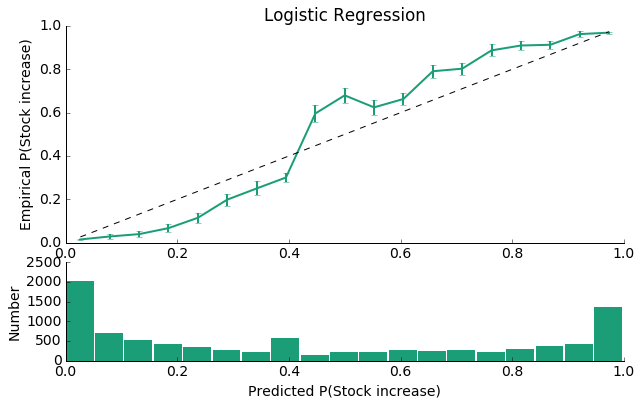

In [41]:
#Logistic regression calibration plot

train_size=36848

ridge_model= lm.LogisticRegression(penalty='l2', C=2000)
ridge_model.fit(X[:train_size,:],y[:train_size])
calibration_plot(ridge_model,X[train_size:,:],y[train_size:],"Logistic Regression")

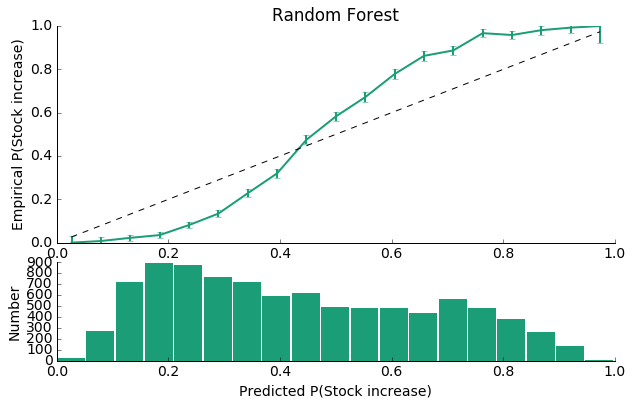

In [42]:
#Random Forest calibration plot

train_size=36848

rf_model=RandomForestClassifier(n_estimators=190)
rf_model.fit(X[:train_size,:],y[:train_size])
calibration_plot(rf_model,X[train_size:,:],y[train_size:],"Random Forest")

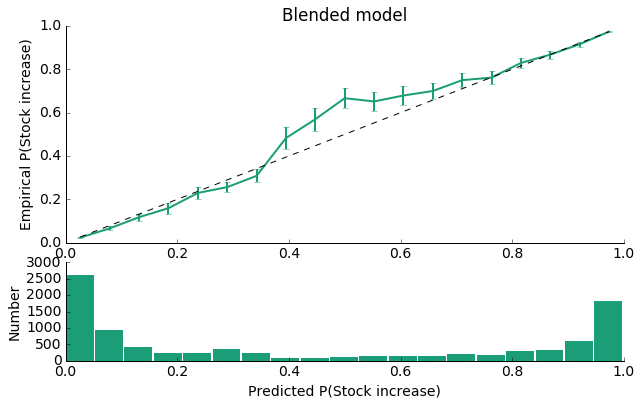

In [44]:
#Ridge+Random Forest Classifier Model

model_stacker.fit(new_X[:train_size,:], new_Y.reshape(new_Y.shape[0])[:train_size]) 
calibration_plot(model_stacker, new_X[train_size:,:], new_Y.reshape(new_Y.shape[0])[train_size:], "Blended model")

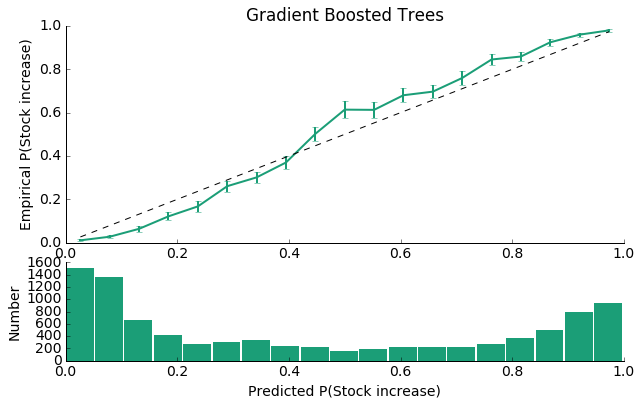

In [46]:
#Gradient boosting classifier model

gbt_model = GradientBoostingClassifier(n_estimators = 200) # define model
gbt_model.fit(X[:train_size,:], y[:train_size]) # train model
calibration_plot(gbt_model, X[train_size:,:], y[train_size:], "Gradient Boosted Trees")